<a href="https://colab.research.google.com/github/Siarzis/ai-tutor/blob/main/cnn_mnist_classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

Load MNIST dataset

In [ ]:
# MNIST is a large database of handwritten digits
# commonly used for prototyping image processing systems

# MNIST includes 60,000 28x28 grayscale images of the 10 digits and a test set of 10,000 images

# define transforms to normalize the MNIST image data
transform = transforms.Compose([transforms.ToTensor(),  # Convert images to tensors, normalize to pixel values to the range [0, 1]
                                transforms.Normalize((0.5,), (0.5,))  # Normalize the pixel values to the range [-1, 1]
                                ])

# define the batch size
bs = 64

# download and load the MNIST training set | "train_dataset" is an object of the dataset class
train_dataset = torchvision.datasets.MNIST(root='./', train=True, download=True, transform=transform)
# "train_loader" is an object of the DataLoader class
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)

# download and load the MNIST test set
test_dataset = torchvision.datasets.MNIST(root='./', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=False)

Get MNIST image properties

In [13]:
print('Total number of MNIST images:', len(train_dataset))

# dataset class is subscriptable => train_dataset[0] is the first image of MNIST
# train_dataset[0] returns a tuble of the image (torch.Tensor) and its label (int)
image, label = train_dataset[0]
print('Image dimensions:', image.size(), 'Image label:', label)
print('Image channels:', image.size()[0])
print('Image size (height x width):', image.size()[1:])

print('Total number of batches:', len(train_dataset), '/', bs, '=', len(train_loader))

Total number of MNIST images: 60000
Image dimensions: torch.Size([1, 28, 28]) Image label: 5
Image channels: 1
Image size (height x width): torch.Size([28, 28])


Visualize a sample image from MNIST

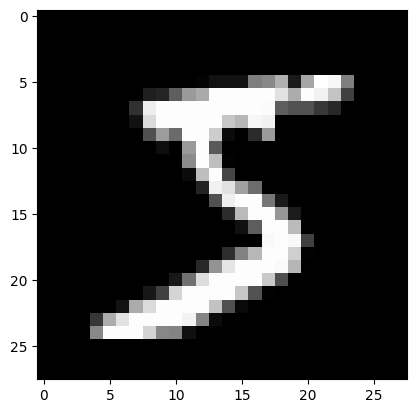

In [14]:
# convert MNIST sample image from PyTorch tensor to a NumPy array
image_np = image.numpy()

# visualize MNIST sample image using Matplotlib

# .squeeze() discards singleton dimensions - used to remove the channel dimension
plt.imshow(image_np.squeeze(), cmap='gray')
plt.show()

Further image visualization

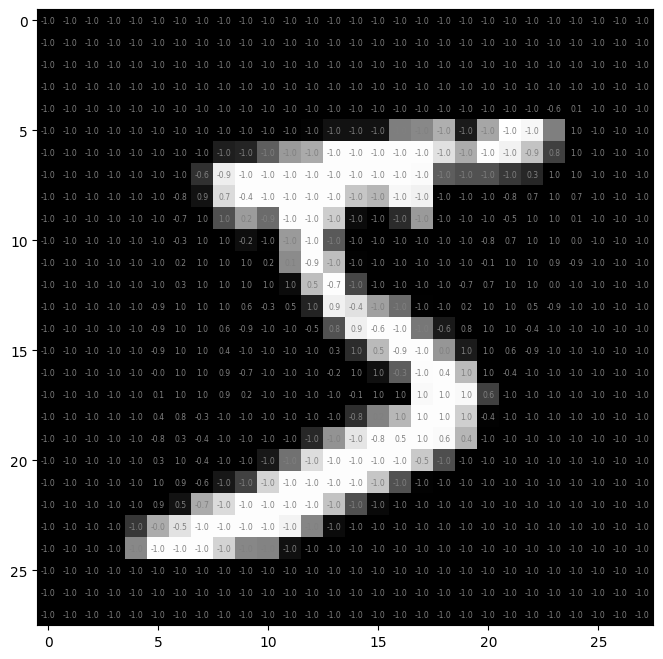

In [45]:
plt.figure(figsize=(8,8))
plt.imshow(image.squeeze(), cmap='gray')

for i in range(28):
    for j in range(28):
        pixel = round(image.squeeze()[i][j].item(), 1)
        plt.text(i, j, pixel, fontsize=5.5, ha='center', va='center', color='gray')